In [1]:
import scanpy as sc
import anndata
from scipy import io
from scipy.sparse import coo_matrix, csr_matrix
import numpy as np
import os
import pandas as pd

In [3]:
# load sparse matrix
X = io.mmread("/home/wuhangrui/R/data/20230516/analysis_in_R/counts.mtx")



In [4]:
# create anndata object
adata = anndata.AnnData(
    X=X.transpose().tocsr()
)

# load cell metadata:
cell_meta = pd.read_csv("/home/wuhangrui/R/data/20230516/analysis_in_R/metadata.csv")

# load gene names:
with open("/home/wuhangrui/R/data/20230516/analysis_in_R/gene_names.csv","r") as f:
    gene_names = f.read().splitlines()

In [5]:
adata

AnnData object with n_obs × n_vars = 2408 × 16746

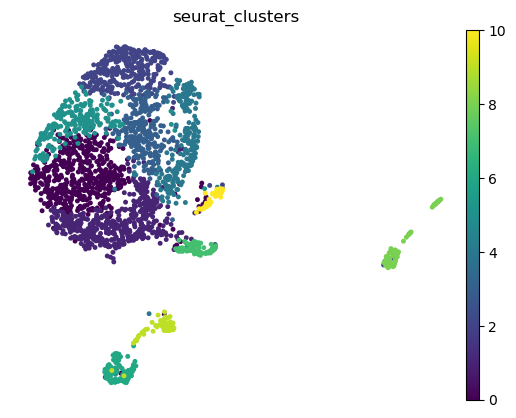

In [6]:
# set anndata observations and index obs by barcodes, var by gene names
adata.obs = cell_meta
adata.obs.index = adata.obs['barcode']
adata.var.index = gene_names

# load dimensional reduction:
pca = pd.read_csv("/home/wuhangrui/R/data/20230516/analysis_in_R/pca.csv")
pca.index = adata.obs.index

# set pca and umap
adata.obsm["X_pca"] = pca.to_numpy()
adata.obsm["X_umap"] = np.vstack((adata.obs['UMAP_1'].to_numpy(), adata.obs['UMAP_2'].to_numpy())).T

# plot a UMAP colored by sampleID to test:
sc.pl.umap(adata,color=["seurat_clusters"], frameon=False, save=True)

In [7]:
# save dataset as anndata format
adata.write("pro.h5ad")

# reload dataset
adata = sc.read_h5ad("pro.h5ad")

In [8]:

##### load data
import scvelo as scv
import scanpy as sc
import cellrank as cr
import numpy as np
import pandas as pd
import anndata as ad

In [9]:
scv.settings.verbosity = 3
scv.settings.set_figure_params('scvelo', facecolor='white', dpi=100, frameon=False)
cr.settings.verbosity = 2

adata = sc.read_h5ad('pro.h5ad')

/home/wuhangrui/miniconda3/envs/scrna/lib/python3.9/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


/home/wuhangrui/miniconda3/envs/scrna/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


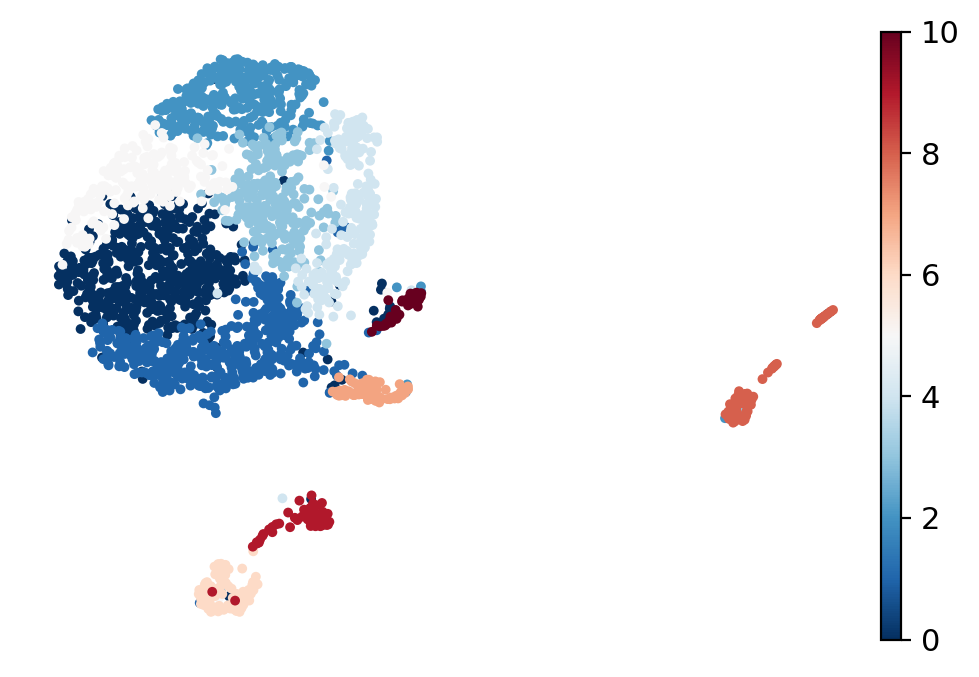

In [10]:
# load loom files for spliced/unspliced matrices for each sample:
ldata1 = scv.read('/home/wuhangrui/R/data/20230516/rawdata/SRR7722937/sample/sample1/velocyto/sample1.loom', cache=True)

barcodes = [bc.split(':')[1] for bc in ldata1.obs.index.tolist()]
barcodes = [bc[0:len(bc)-1] + '-1' for bc in barcodes]
ldata1.obs.index = barcodes

# make variable names unique
ldata1.var_names_make_unique()

# merge matrices into the original adata object
adata = scv.utils.merge(adata, ldata1)
# plot umap to check

sc.pl.umap(adata, color='seurat_clusters', frameon=False, legend_loc='on data', title='', save='_celltypes.pdf')

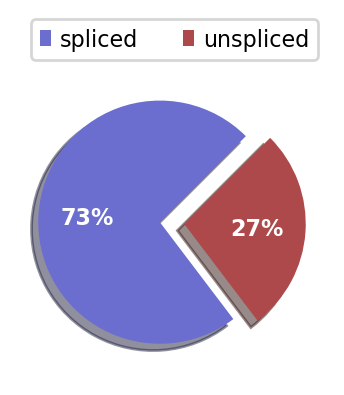

Normalized count data: X, spliced, unspliced.
computing neighbors
    finished (0:00:07) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:02) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [11]:
#### compute RNA velocity
scv.pl.proportions(adata)
# pre-process
scv.pp.filter_and_normalize(adata)
scv.pp.moments(adata)

In [12]:
# compute velocity
scv.tl.velocity(adata, mode='stochastic')
scv.tl.velocity_graph(adata)

computing velocities
    finished (0:00:03) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/24 cores)
or disable the progress bar using `show_progress_bar=False`.
    finished (0:00:20) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


/home/wuhangrui/miniconda3/envs/scrna/lib/python3.9/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res


computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
saving figure to file ./figures/scvelo_embedding.pdf


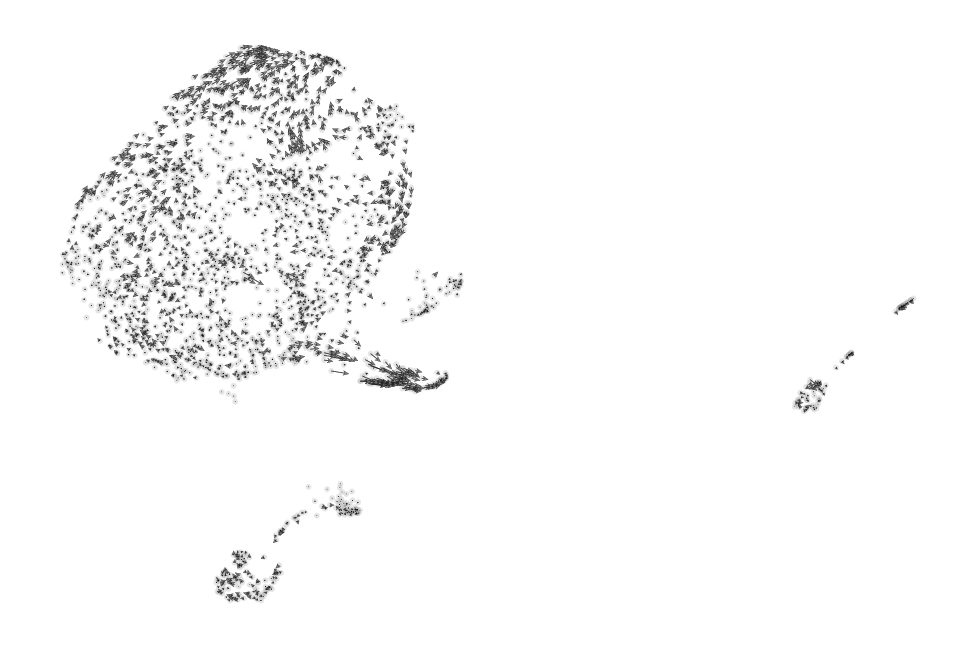

In [24]:
# visualize velocity fields
scv.pl.velocity_embedding(adata, basis='umap', frameon=False, save='embedding.pdf')

saving figure to file ./figures/scvelo_embedding_grid.pdf


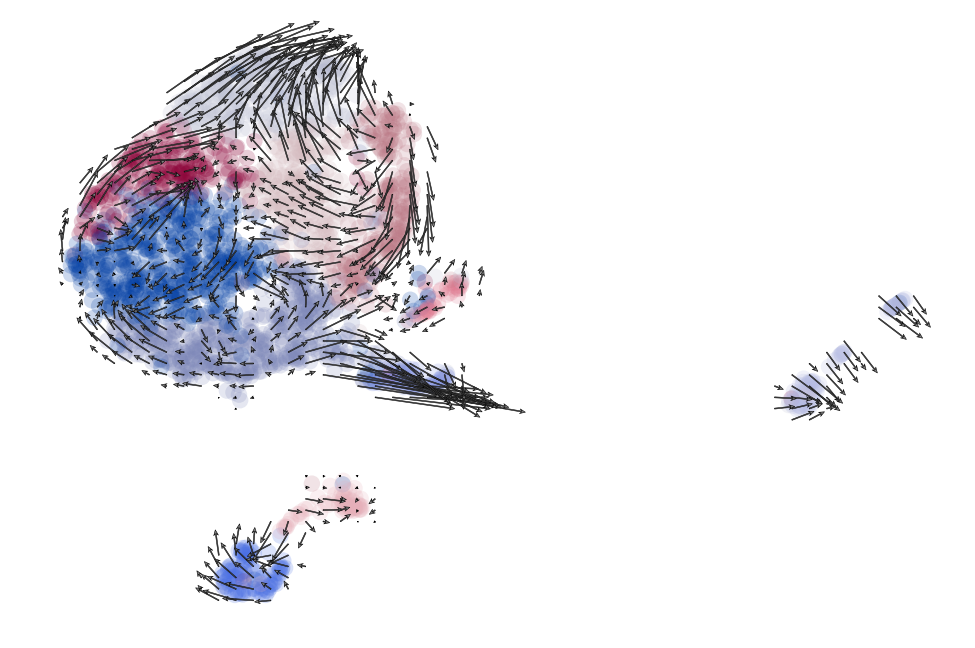

In [25]:
scv.pl.velocity_embedding_grid(adata, basis='umap', color='seurat_clusters', save='embedding_grid.pdf', title='', scale=0.25)

/home/wuhangrui/miniconda3/envs/scrna/lib/python3.9/site-packages/scvelo/plotting/scatter.py:614: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(
/home/wuhangrui/miniconda3/envs/scrna/lib/python3.9/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()
/home/wuhangrui/miniconda3/envs/scrna/lib/python3.9/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


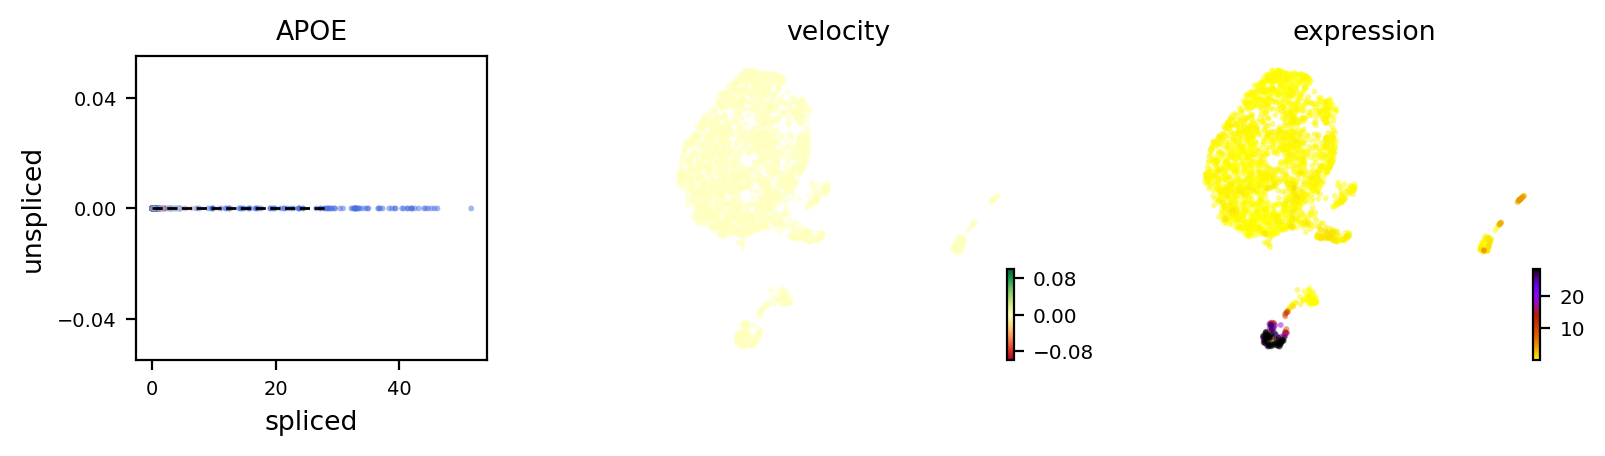

In [27]:
# plot velocity of a selected gene
scv.pl.velocity(adata, var_names=['APOE'], color='seurat_clusters')

/home/wuhangrui/miniconda3/envs/scrna/lib/python3.9/site-packages/scvelo/plotting/scatter.py:614: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(
/home/wuhangrui/miniconda3/envs/scrna/lib/python3.9/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()
/home/wuhangrui/miniconda3/envs/scrna/lib/python3.9/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


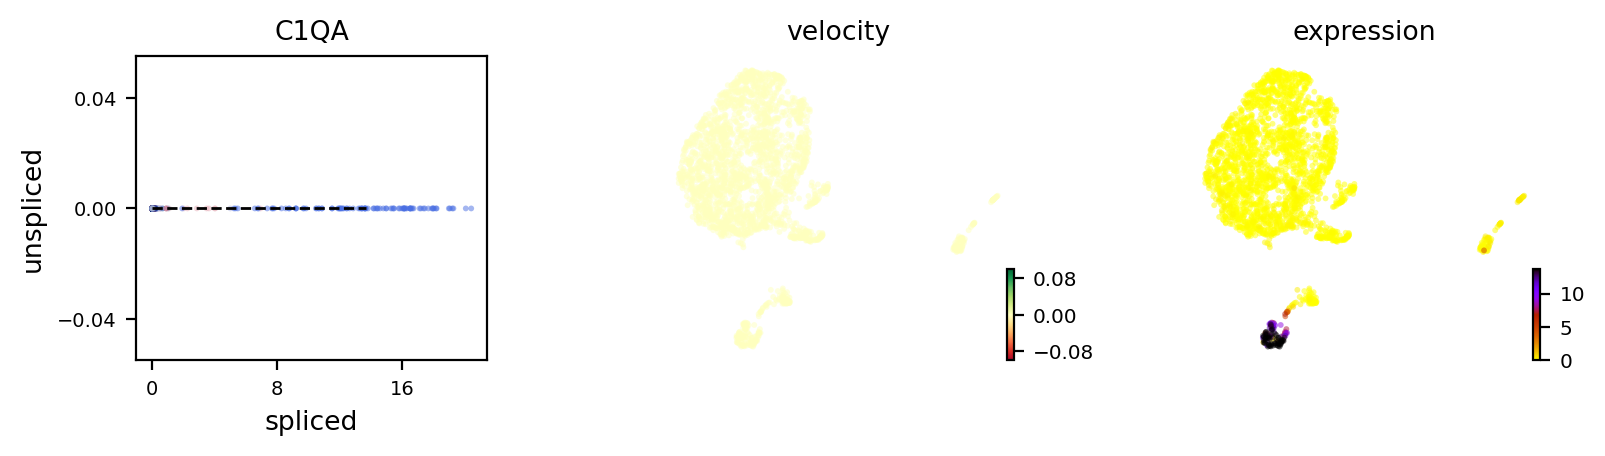

In [28]:
# plot velocity of a selected gene
scv.pl.velocity(adata, var_names=['C1QA'], color='seurat_clusters')

In [13]:
adata.write("state_trans.h5ad")